#Lecture 12: Hamiltonian Monte Carlo

AM207: Pavlos Protopapas, Harvard University

March 6, 2014


------


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns

from IPython.core.display import Image

$$
\newcommand{\var}{{\rm var}}
\newcommand{\cov}{{\rm cov}}
\newcommand{\corr}{{\rm corr}}
\newcommand{\xss}{x^{(i+1)}}
\newcommand{\xs}{x^{\star}}
\newcommand{\xt}{x^{(i)}}
\newcommand{\yss}{y^{(i+1)}}
\newcommand{\ys}{y^{\star}}
\newcommand{\yt}{y^{(i)}}
\newcommand{\xa}{x_a}
\newcommand{\xb}{x_b}
$$

#Introduction 

In the 1960's and 70's two main family of methods arose for the practical simulation for large many particle systems.  One of them is the Monte Carlo (and in particular MCMC) family of algorithms that we've already covered, which took a large scale sampling approach to simulating many particle systems.  The other family of approaches is known as Molecular Dynamics and involved applying the laws of motion to each particle and deterministically simulating the system.  Hamiltonian Markov Chain Monte Carlo (also known as Hybrid MCMC) or HMC -- conveniently the abbreviation works for both names -- can be considered the child of these two families of methods.

HMC was introduced in 1987 in a paper by Duane, Kennedy, Pendleton, and Roweth where they applied the method to lattice field theory simulations of quantum chromodynamics.  Radford Neal made the method popular in the statistical community with papers in 1993, 1996, and 2011.  A lot of HMC's recent appreciation as an MCMC method is due to Neal, and we'll follow (and in doing so borrow heavily from) his formulation of the method in this lecture.



## A Trip Down Memory Lane

The core idea behind Hamiltonian Monte Carlo is that it is possible to augment the target distribution from which you're trying to sample to create a joint distribution in which the additional random variables can be used to control the dynamics with which you traverse your target distribution.  We've learned (via Gibbs Sampling, Slice Sampling and Data Augmentation) MCMC techniques to augment our target distribution and sample over the additional parameters in a way that preserves our (now marginal) target distribution.  Let's briefly recall those techniques.

###Sampling From Conditionals

Gibbs sampling allows you to sample from a probability distribution by iteratively sampling from its **conditional** distributions. This strategy is very useful in problems where each unknown would have a very simple distribution if we knew all of the other unknowns. To perform Gibbs sampling, we first initialize the sampler with initial values and at each iteration $i$, we 
we sample first a new value for $\xss_1$  that is conditional to $\xt_2$,
the previous step of the second component and we do that by drawing from 
$p(x_1|x_2=\xt_2)$. In contrast with MH, we will always accept this proposal.
The new state is updated immediately without checking the acceptance probability. 
In the next step, we sample a new value of $\xss_2$ conditional on $\xss_1$, which is 
the current step of the first component.
The procedure is iterative conditional sampling; we go back and forth by sampling the new 
state by conditioning on the current values for the other component. 
In summary:

1. Set i=1
2. Initialize ${\bf \xt}={\bf u}$ where ${\bf u}=(u_1,u_2)$. 
3. Repeat 
    1. Sample $\xss_1$ from the conditional $p(x_1|x_2=\xt_2)$ 
    1. Sample $\xss_2$ from the conditional $p(x_2|x_1=\xss_1)$
    
### Data Augmentation

Recall from previous lectures that the basic idea behind Data Augmentation is to resolve difficulty in simulate from $p(x)$ using the traditional methods by constructinga joint pdf such that:

$$ \int p(x,y)\, dy = p(x)  $$

and simulating from the associated conditional pdfs, $p(x|y)$ and $p(y|x)$ is easy.

The DA algorithm is based on this joint pdf, and we *marginalize* over the **augmenting variable** $y$ to obtain samples for $p(x)$.

The first property allows for a construction of Markov chain (see below for the proof). 


The simplest form of DA algorithm takes the following form:

1. Draw $Y\sim P_{Y|X}(.|x)$ and call the observed value y
2. Draw $X_{n+1} \sim P_{X|Y}(.|y)$

After discarding the samples $Y_i$, we have our remaining samples $X_i \sim P(x)$.

## Lookig for the perfect MCMC?

The problem with MH is that is sensitive to the step size, Gibbs we need to know how to draw from the conditionals. What we want is the ability to adjust the step size but at the same time preserving the properties of MCMC, namely being able to sample the whole space and at the same time converge to the target distribution. We also would like to have no burnin, no autocorrelation, guarantee mixing and convergence very fast and no tunable parameters (and a pony). 

Lets start with the first two requirements. Firstly we would like to have a method that the step size is automatically adjusted. The wish list is as follows:

3. Decelerrating/accelerating when those derivatives are large 
4. Decelerrating/accelerating when those derivatives are small 
5. Accept proposal if the new position increases p(x) with probability one
6. Accept proposal if the new position decreases p(x) with some probabillity 

The figure below shoes those requirements

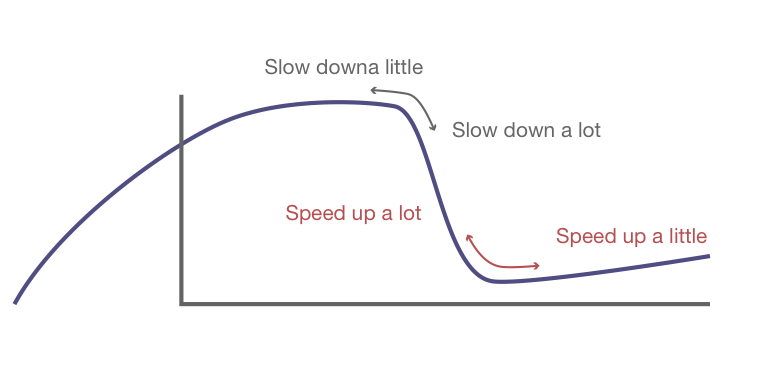

In [2]:
Image('./Lecture13_data/Lecture13_Hamiltonian_6_0.png', width=600)

How do we achieve this while at the same time preserving the MCMC properties. 

We know we can achieve #3 by having acceptance probabiity proportional to $p(x^*)/p(x)$ or some other function $f(x^*)/f(x)$ where $f(x)$ is a monotone of $p(x)$. For example we can use $e^{-U(x)}$ as long as $U(x)$ is a monotone of $p(x)$. Simply we could use:

$$U(x) = - \ln(p(x))$$

without changing the acceptance probabillity.

Now lets visit #1 and #2. We know from requirements #1 and #2  that

1. If $\Delta p(x) >0 $ we want to be always accept 
    1. $\Delta p(x) $ small we want to continue our walk with minor accelaration
    2. $\Delta p(x) $ large we want to continue our walk with large accelaration

2. If  $\Delta p(x) <0 $ we want accept with some probability proportional to $\Delta p(x)$
    1. $\Delta p(x) $ small we want to continue our walk with minor deceleration
    2. $\Delta p(x) $ large we want to continue our walk with large deceleration (most likely always reject)


$U(x)$ is basically the opposite of $p(x)$

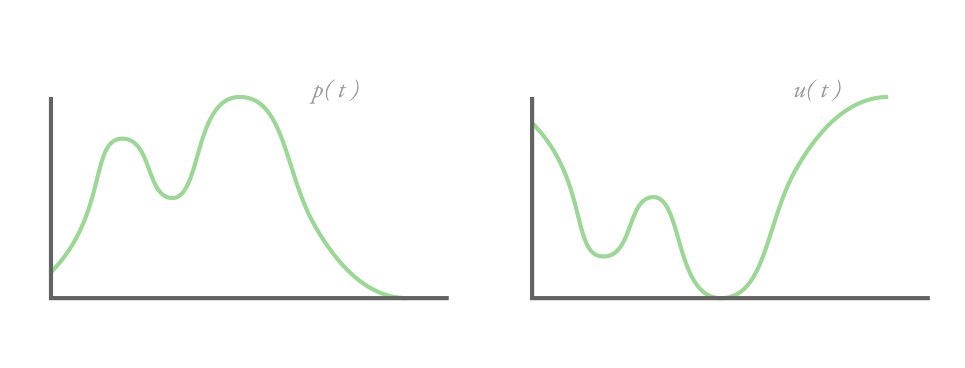

In [3]:
Image('./Lecture13_data/Lecture13_Hamiltonian_8_0.png', width=600)

To achieve our goal we introduce a new variable as we did for DA and Slice Sampling we now call $y$. As we explained in the DA lecture the new joint distribution 

$$p(x) = \int p(x,y) \, dy $$

An easy way to achieve this is if $p(x,y)=p(x)p(y)$. And since we can choose our joint distribution as we like, we choose (the reasons will be obvious soon). 

$$ p(x,y) = e^{-U(x)-y^2/2m} = e^{-U(x)} e^{-y^2/2m}$$

Where $m$ is just a constant thus  $p(y)$ is  Gaussian. Or the kinetic energy if $y$ is the momentum and from second year of kindergarten we know that $K=y^2/2m$.  Also we can think of $U(x)$ as the potential energy and therefore the exponent now is the total energy. 

We change the notation from now on to be more consistent with the literature. 

$$ x \rightarrow q$$
$$ y \rightarrow p$$ 

We also know that if we follow Newton's law the negative of the derivative of the potential is the force, which we know $F=ma$ (this is from my son's science notebook). 

Therefore if $\Delta(U) <0$ we have ecceleration and  $\Delta(U)>0$ we have decceleration. 

1.  $\Delta(P(q))>0 \rightarrow \Delta(U(q))<0 \rightarrow$ acceleration. And larger the derivative the larger the acceleration. 
2.  $\Delta(P(q))<0 \rightarrow \Delta(U(q))>0 \rightarrow$ decceleration. And larger the derivative the larger the decceleration.

Almost there. 
If we follow Neotonian mechanics and we propose base on the laws of physics and accept/reject base on the usual MH acceptance probability

$$ A = \min \left[ 1, \frac{P(q^*,p^*)}{P(q,p)} \right] $$

we achieve our goals from above. 

Not there yet. Remaining issues:


2. How do we actually proposed a new position? Discretizing Newtons law introduce errors. 
3. Is this a Markov Chain? 
1. If we just follow Newtonian mechanics, we do not have any randomness and we just follow a ball rolling on the hill. 

First lets refresh our basic knowledge of mechanics



##What the Hamiltonian is Hamiltonian Dynamics?

Now that we've reviewed augmenting our target distribution, it only remains to use our new joint posterior to construct "Hamiltonian Dynamics" within our MCMC sampler.  One small matter needs to be addressed before we do so.  **What are Hamiltonian Dynamics?**

Well, as I'm sure many of you know, there are three common formalisms used to pose and analyze problems in classical mechanics: Newtonian Dynamics, Lagrangian Dynamics, and Hamiltonian Dynamics.  The three systems are equivalent and all completely describe what we know about classical mechanics, but various problems are more conveniently formulated in one or another.  Let's briefly glance at each with a little more of a detailed focus on Hamiltonian Dynamics.

### Newtonian Mechanics

In Newtonian Mechanics, force plays a central role.  We're all familiar with the three laws of motion, but the law we are concerned about is the famous second law:

$$ F(x_i, \dot{x_i}, t) = m \frac{d}{dt} \dot{x_i} $$

where $ x_i $ is the ith position, $ \dot{x_i} $ is the ith velocity, and t is  time.  This equation defines all relevant motion (or dynamics) in Newtonian physics.

### Lagrangian Mechanics [IGNORE]

The Lagrangian formulation focuses around a new function $ L(x_i,\dot{x_i}, t) $ named (creatively) the Lagrangian which is governed by the following set of equations (commonly known as the Euler-Lagrange Equations):

$$ \frac {\partial L}{\partial x_i} - \frac{d}{dt} \frac {\partial L}{\partial \dot{x_i}} = 0 $$
for conservative forces and
$$ \frac {\partial L}{\partial x_i} - \frac{d}{dt} \frac {\partial L}{\partial \dot{x_i}} = Q_i $$
when non-conservative forces $ Q_i $ are involved.

It's common to define the **action S** as the path integral of L along a path that starts at $ t_0 $ and ends at $ t_f $:

$$ S = \int_{t=t_0}^{t=t_f}L(x_i,\dot{x_i}, t)dt $$

The action is a function of the path which itself is a vector function of $(x, \dot{x},t)$. Consider a shortest path $z(x(t))$ from $x(t_i)$ to $x(t_f)$.  If we look at a slight variation $x(t) \rightarrow x(t) + \delta x(t)$ on the path and consider the effect of that variation on the action S of the shortest path, we see $z(x(t))$ will change by $\frac{d\delta z(t)}{dt} = \delta\dot{x} $.  The variation in S will be:
$$ \delta S = \int_{t=t_0}^{t=t_f}\left (\frac{\partial L}{\partial x_i}\delta x_i + \frac{\partial L}{\partial \dot{x_i}}\delta x_i  \right)dt $$
Using integration by parts on the term on the right we get:
$$ \delta S = \left. \frac{\partial L}{\partial x_i}\delta x \right|_{t_i}^{t_f} + \int_{t=t_0}^{t=t_f}\left (\frac{\partial L}{\partial x_i} - \frac{d}{dt}\frac{\partial L}{\partial \dot{x_i}} \right)\delta x_i dt $$
The left term goes to zero because $\delta x$ must be 0 at the endpoints of the path (the variation of the path doesn't include the endpoints).  The terms in the integral show that for the Lagrangian (which meets the Euler-Lagrange conditions) $ \delta S $ will be 0 and S will thus be minimized.  The Lagrangian will select the shortest path between two points in configuration space.

Another important characteristic of the Lagrangian formulation is that the Euler-Lagrange equtions can be shown to be invariant to coordinate transformations (as opposed to the Newtonian formulation in which coordinate transformations can be very messy).  So we've used $ (x_i, \dot{x_i}, t) $ but it's common to use $ (q_i, \dot{q_i}, t) $ to represent generalized coordinates in the Lagrangian formulation.

If Newtonian and Lagrangian Mechanics are equivalent, how do you go from Newton's Equations to the Lagrange-Euler equations?  For a conservative force:

$$ F_i = ma_i = m\ddot{x} $$

where $ F_i $ is completely determined by the potential energy V and $m\ddot{x} $ is determined fully by the kinetic energy T.  Consider that $T = \frac{1}{2}m\dot{x}^2$ we have that $m\ddot{x} = \frac{d}{dt} \frac{\partial T}{\partial \dot{x}}$.  Similarly $F_i = - \frac{\partial V}{\partial x}$.  Thus, set the Lagrangian to  $L = T - V$.



### Hamiltonian Mechanics

You may have noticed that Lagrangian Formulation operates in a configuration space $ \{q, \dot{q} \} $ and has as it's central equations of motion second order differential equations.  Given a configuration space $ \{q_i, \dot{q_i} \} $  and a Lagrangian function $ L(q_i, \dot{q_i}, t) $ we can use a Legendre transform to construct a new space  $ \{q_i, p_i \} $ (known as phase spaces) and a new function $ H(q_i, p_i, t) $ known as the Hamiltonian.  Given a Hamiltonian H, the Hamiltonian equations of motion are as follows:

$$ \frac{dp_i}{dt}  = -\frac {\partial H}{\partial x_i} $$
$$ \frac{dx_i}{dt}  = \frac {\partial H}{\partial p_i} $$

The Hamiltonian can be derived from the Lagrangian by the Legendre transform
$$ p_i = \frac {\partial L}{\partial \dot{x_i}} $$
$$ H(q_i, p_i, t) = \sum_i (p_i\dot{q_i}) -L $$

#### The Hamiltonian is conserved
If the Hamiltonian H doesn't have a functional dependence on time we see that 

$$ \frac{dH}{dt} = \sum_i \left[\frac {\partial H}{\partial x_i}\frac{dx_i}{dt} + \frac {\partial H}{\partial p_i}\frac{dp_i}{dt} \right] + \frac{\partial H}{\partial t} $$

Substituting in the Hamiltonian equations of motion we can see:
$$ \frac{dH}{dt} = \sum_i \left[\frac {\partial H}{\partial x_i}\frac {\partial H}{\partial p_i} + (\frac {\partial H}{\partial p_i})(-\frac {\partial H}{\partial x_i}) \right] + \frac{\partial H}{\partial t} $$


So as long as the Hamiltonian $ H(q_i, p_i, t)$ depends only on $ \{q_i, p_i \} $ then it is conserved and

$$ \frac{dH}{dt} = \frac{\partial H}{\partial t} = 0\ \Rightarrow H(t + \Delta t) = H(t) \, \forall t $$

#### On being symplectic

Define the Hamiltonian equations in vector form. We can write our state vector as 

$$ z = \left( \begin{array}{c}
 q_1 \\
 \vdots \\
 q_n \\
 p_1 \\
 \vdots \\
 p_n  \end{array} \right) $$
we can write the Hamiltonian equations in vector form

$$ \frac{dz}{dt} = \Omega \nabla H(z) $$

with $ [\nabla H]_{ij} = \frac{\partial }{\partial z_i}\frac{\partial H}{\partial z_j} $ and 

$$ \Omega = \left( \begin{array}{cc}
0 & I_n \\
-I_n & 0  \end{array} \right) $$

Note that $\Omega' = - \Omega $ and also that $ \Omega^2 = -I_{2n} $ where $ I_k $ is the k x k Identity Matrix.  We say a 2n x 2n matrix M is **symplectic** if it satisfies $ M'\Omega M = \Omega $.

How does this bear on Hamiltonian systems?  Well $ [\nabla H]_k = J\vec{z} $ where J is a symmetric matrix (i.e. J' = J).  Then Hamilton's equations:

$$ \frac{d\vec{z}}{dt} = \Omega \nabla H(z) = \Omega J\vec{z} $$ has a solution:
$$ \vec{z}(t) = M(t)\vec{z}(t_0)  $$  
where $ \vec{z}(t_0) $ is the position in phase space at $ t_0 $.  The solution to this matrix differential equation is $ \vec{z}(t) = e^{t\Omega J} $ in the sense of the matrix exponential. (You can use power series of matrix operators to determine this.

Lemma:  $ \Omega e^{t\Omega J} = e^{tJ\Omega}\Omega $

Proof:  TBD.

If we accept the Lemma, then 

$$ M'(t)\Omega M(t) = e^{-t\Omega J}\Omega e^{t\Omega J}  $$
$$ = e^{-t\Omega J}e^{tJ\Omega}\Omega = \Omega $$

i.e. M(t) is symplectic!!

### The Hamiltonian preserves volume in phase space
Once we know that the transformation describing the equations of motion are symplectic, we can deduce two very important properties of Hamiltonian dynamics.  The first is that volumes in phase space are conserved.
 
Remember since our transformation M(t) is symplectic, the absolute value of determinant (or more properly the determinant of its Jacobian) is one since 

$$ det(M'(t)\Omega M(t)) = det(\Omega) \rightarrow det(M'(t))det(\Omega)det(M(t))= det(\Omega) $$

A simple calculation shows $det(\Omega)$ = 1.  It follows that 

$$ det(M'(t))det(M(t)) = det(M(t))^2 = 1 $$

Thus, M(t) preserves volumes in phase space.

#### Reversibility

We've shown that any transformation M(t) in a Hamiltonian system is non-singular i.e. $ det(M(t) \neq 0 $.  Thus M(t) is invertible (in other words reversible).  In particular,

$$ M^{-1}(t) = \Omega^{-1} M'(t)\Omega $$ 

This basically means that within any trajectory in the phase space we preserved the volume and therefore if we do random jumps and 

## Simulating Hamiltonian Systems:  Discretization

Unfortunately we can't simulate Hamiltonian systems exactly and we have to rely on discretization!  What does that mean?  Well in the derivations above, we assumed that we could solve the differential equations in question exactly.  Since we're going to be sampling from our Hamiltonian dynamics we need to discretize our systems in to small timesteps of size $ \epsilon $.  

There are a number of discretization methods available for simulating dynamics systems.  It turns out that all of them aren't equally useful.  Some of the properties of the Let's start with the simplest, Euler discretization.  In all of our discretization examples we'll make the following assumptions:

* the Hamiltonian has the form H(q, p) = U(q)+K(p)
* K(p) = $p'M^{-1}p $ so that $K(p) = \sum_i\frac{p_i^2}{2m_i} $ and M is square with diagonal elements $ 1/m_i $

Let's start with the most basic discretization, Euler's method.

### Euler Discretization

Euler discretization involves directly updating the momentum and position at each time step.  The algorithm is as follows:

* $p_i(t + \epsilon) = p_i(t) - \epsilon \frac{\partial U}{\partial q_i}\mid_{q(t)} $
* $q_i(t + \epsilon) = q_i(t) + \epsilon \frac{p_i(t)}{m_i} $

See code and plot below for harmonic oscillator, $ H = U(q) + K(p) = \frac{q^2}{2} + \frac{p^2}{2m} $.  Notice that the volume is not preserved as the  trajectory we plot for the harmonic oscillator, which should be an elipse, diverges to infinity and the Hamiltonian is not conserved as we'd expect it to be.  Something is wrong with this discretization.  Let's try another approach.

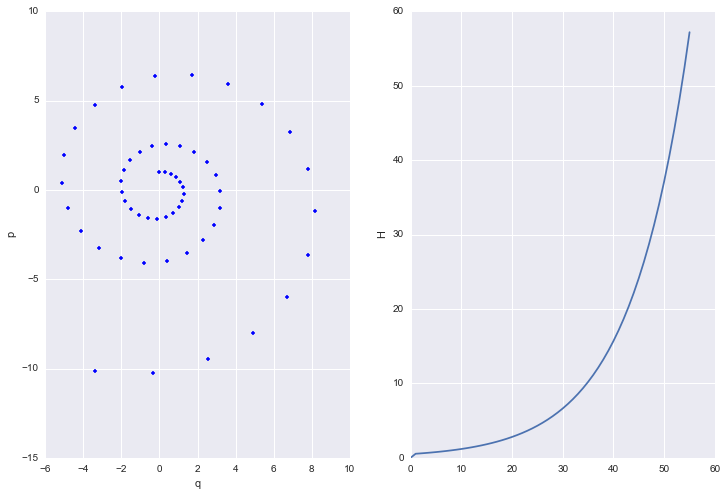

In [4]:
U = lambda q: q**2/2
K = lambda p:  (p**2)/2
dUdq= lambda q: q

def euler(p0, q0, L, epsilon):
    
    ps = [p0]
    qs = [q0]
    
    pprev = p0
    qprev = q0
    


    # alternate full steps for position and momentum
    for i in xrange(L):
        p = pprev - epsilon*dUdq(qprev)
        ps.append(p)
        q = qprev + epsilon*pprev
        qs.append(q)
        
        pprev = p
        qprev = q


    
    return (ps, qs)


eps,eqs = euler(1,0, 55, .3)
h = [U(q) + K(p) for q, p in zip(eqs, eps)]

plt.figure(figsize=[12,8])
plt.subplot(1,2,1)
plt.plot(eqs,eps, 'b.')
plt.xlabel('q')
plt.ylabel('p')
plt.subplot(1,2,2)
plt.plot(h)
plt.ylabel('H')

### Modification of Euler Discretization

We can modify Euler discretization slightly by using a the same discretization but updating position at each time step using the updated calculation for the momentum.  The algorithm is as follows:

* $p_i(t + \epsilon) = p_i(t) - \epsilon \frac{\partial U}{\partial q_i}\mid_{q(t)} $
* $q_i(t + \epsilon) = q_i(t) + \epsilon \frac{p_i(t+\epsilon)}{m_i} $

We try the new discretization on the same Harmonic Oscillator Hamiltonian that we tried with the Euler method.  Note from the code and plot below that the trajectory in phase space is a stable elipse as we expect for the harmonic oscillator.  Also note that while H no longer  diverges to infinity it's not constant as we'd expect for a perfect Hamiltonian.  Due to discretization errors H oscillates around the correct value.


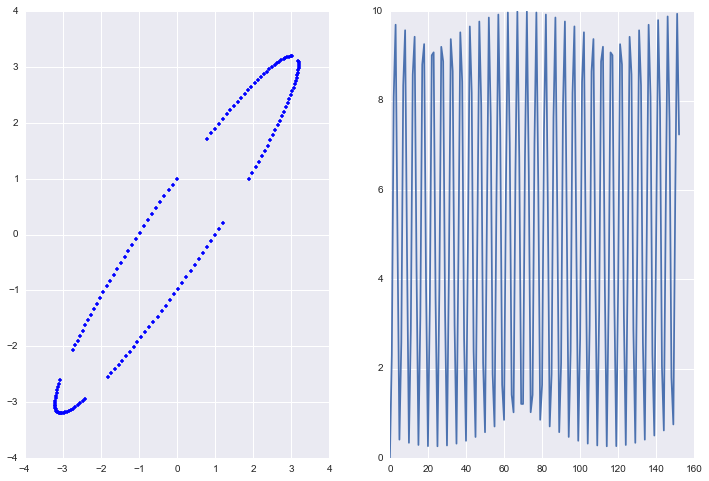

In [5]:
U = lambda q: q**2/2
K = lambda p:  (p**2)/2
dUdq= lambda q: q

def eulernew(p0, q0, L, epsilon):
    
    ps = [p0]
    qs = [q0]
    
    pprev = p0
    qprev = q0
    


    # alternate full steps for position and momentum
    for i in xrange(L):
        p = pprev - epsilon*dUdq(qprev)
        ps.append(p)
        q = qprev + epsilon*p
        qs.append(q)
        
        pprev = p
        qprev = q


    
    return (ps, qs)



eps,eqs = eulernew(1,0, 152, 1.9)
h = [U(q) + K(p) for q, p in zip(eqs, eps)]

plt.figure(figsize=[12,8])
plt.subplot(1,2,1)
plt.plot(eqs,eps, 'b.')
plt.subplot(1,2,2)
plt.plot(h)

### Leapfrog method

A final discretization called the leapfrog method involves stage-wise updating the momentum and position.  The algorithm is as follows:

* $p_i(t + \frac{\epsilon}{2}) = p_i(t) - \frac{\epsilon}{2}\frac{\partial U}{\partial q_i}\mid_{q(t)} $
* $q_i(t + \epsilon) = q_i(t) + \epsilon \frac{p_i(t+\frac{\epsilon}{2})}{m_i} $
* $p_i(t + \epsilon) = p_i(t+\frac{\epsilon}{2}) - \frac{\epsilon}{2}\frac{\partial U}{\partial q_i}\mid_{q(t+ \epsilon)} $


Notice that  volume is preserved and the trajectory is very stable.  In addition the discretization is reversible.  The leapfrog method (named because updating momentum and position leapfrog each other) is a symplectic discretization.  There are other symplectic discretization but this is the one almost exclusively used in practice. 

One thing to note is that even though the discretization is symplectic it (like the Euler modification) doesn't preserve the Hamiltonian perfectly.  That's because of the approximation errors incumbant in discretization.  The error is very stable and the value of the Hamiltonian at each step oscillates around the true value.  When we sample from the potential in our HMC, we will use the acceptance probability to balance out the error in H.

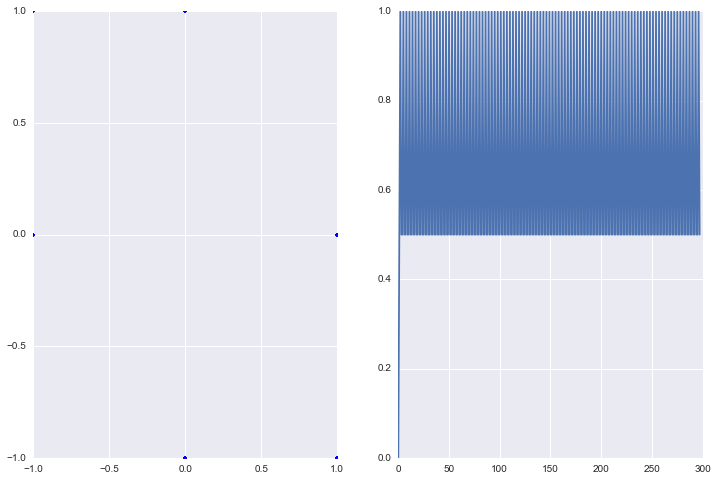

In [6]:
U = lambda q: q**2/2
K = lambda p:  (p**2)/2
dUdq= lambda q: q

def leapfrog(p0, q0, L, epsilon):
    
    ps = [p0]
    qs = [q0]
    
    p = p0
    q = q0
    
    # Make a half step for momentum at the beginning
    p = p - epsilon*dUdq(q)/2.0

    # alternate full steps for position and momentum
    for i in xrange(L):
        q = q + epsilon*p
        qs.append(q)
        if (i != L-1):
            p = p - epsilon*dUdq(q)
            ps.append(p)

    #make a half step at the end
    p = p - epsilon*dUdq(q)/2.
    ps.append(p)
    
    return (ps, qs)



lps,lqs = leapfrog(1,0, 297, 1. )
h = [U(q) + K(p) for q, p in zip(lqs, lps)]

plt.figure(figsize=[12,8])
plt.subplot(1,2,1)
plt.plot(lqs,lps, 'b.')
plt.subplot(1,2,2)
plt.plot(h)

### Sample the Kinetic

In theory we can choose any Kinetic Energy function K(p) that we deem useful.  In practice we use (as described above):

* K(p) = $p'M^{-1}p $ so that $K(p) = \sum_i\frac{p_i^2}{2m_i} $ and M is square matrix with diagonal elements $ 1/m_i $





### Stochasticity 
If we simply follow Leap Frog and Hamiltonian dynamic, we simply re-invented hill climbing. 
However if we draw p from a distribution that is determined by the distribution of momentum, i.e. $\exp(-K(p)) \sim  N(0,M)$ we have a full probabilistic model and the target joint distribution will follow $P(q,p)$.  

### The Acceptance Probability

At the beginning of each sampling step we choose a new $p$ and our current $q$ and then run the Leapfrog algorithm for $L$ steps of size $ \epsilon $. The new $q$ and $p$ at the end of our Leapfrog steps is our new proposed values and we accept with probability 

$$A= \min[1, \exp(-U(q^*)+U(q)-K(p^*)+K(p)] $$





   
   
### The HMC Algorithm

Now that we have the tools in place, let's describe the HMC algorithm.  We're going to assume as above a Kinetic Energy $ K(p) = \frac{p^{\top}M^{-1}p}{2}  $.  The algorithm is as follows

* for i=1:N_samples
    1. Draw $  p \sim N(0,M) $
    2. Set $ q_{c} = q^{(i)} $ where the subscript $c$ stands for current
    3. $ p_c = p $
    4. Update momentum before going into LeapFrog stage: $ p^* = p_c - \frac{\epsilon * \nabla U(q_c)}{2} $  
    5. LeapFrog to get new proposals. For j=1:L
        * $ q^{*} = q^{*} + \epsilon  p $
        * if not the last step, $ p = p - \epsilon  \nabla U(q) $
    6. Complete leapfrog: $ p = p - \frac{\epsilon  \nabla U(q)}{2} $
    7. $ p^{*}= -p $
    8. $ U_c = U(q_c), \,\,\, K_c = \frac{p_c^{\top}M^{-1}p_c}{2} $
    9. $ U^{*} = U(q^*), \,\,\, K^{*} = \frac{p^{\top*}M^{-1}p^*}{2} $
    10. $ r \sim \rm{Unif}(0,1) $
    11. if $ r < e^{(U_{c}-U^{*}+K_{c}-K^{*})} $  
       * accept $q_i = q^*$
       * otherwise reject
       
       
       
 Why #7? According to Neal 2012 is to make the proposal symmetric. It makes no sense unless #1 is center around previous p

### Example: Draw samples from $\exp(-x)$

In [7]:
#constants
epsilon = .010
L = 100
N=100000

# function
P = lambda q: (q>0)*np.exp(-q)
U = lambda q: -np.log(P(q)) +1
K = lambda p:  (p**2)/2
dUdq= lambda q: 1





In [8]:
current_q =0.1
current_p = 1
p_mu=0.
p_sig=1.
H = np.zeros(N)
qall = np.zeros(N)

for j in xrange(N):

    q = current_q
    p = current_p
    
    #draw a new p
    p = np.random.normal(p_mu, p_sig)

    current_p=p

    # leap frog
    
    # Make a half step for momentum at the beginning
    p = p - epsilon*dUdq(q)/2.0


    # alternate full steps for position and momentum
    for i in xrange(L):
        q = q + epsilon*p
        if (i != L-1):
            p = p - epsilon*dUdq(q)

    #make a half step at the end
    p = p - epsilon*dUdq(q)/2.

    # negate the momentum
    p= -p;
    current_U = U(current_q)
    current_K = K(current_p)

    proposed_U = U(q)
    proposed_K = K(p)
    A=np.exp( current_U-proposed_U+current_K-proposed_K)
    
    # accept/reject
    if np.random.rand() < A:
        current_q = q
        qall[j]=q
    else:
        qall[j] = current_q

    H[j] = U(current_q)+K(current_p)


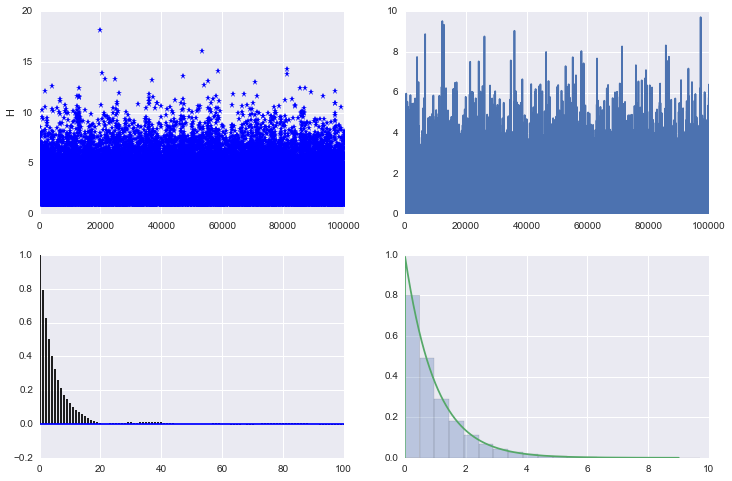

In [9]:
plt.figure(figsize=[12,8])
plt.subplot(2,2,1)
plt.plot(H, 'b*')
plt.ylabel('H')

plt.subplot(2,2,2)
plt.plot(qall)
plt.subplot(2,2,3)
fig=plt.acorr(qall-np.mean(qall), normed=True, maxlags=100)
plt.xlim( [0,100])
plt.subplot(2,2,4)
plt.hist(qall,20, normed=True, alpha=0.3);
points = np.linspace(0,9,1000)
plt.plot(points, P(points))

## Ergodicity of HMC

* In general we expect that HMC will be ergodic, but it's possible to select values of $L$ and $\epsilon$ for which the underlying Markov Chain is periodic or near periodic.  
* Consider our example in the deterministic case where $ H = \frac{q^2}{2} + \frac{p^2}{2m} $.
* Look at the plots below for $ \epsilon = \frac{\pi}{25} $ vs $ \epsilon = 0.3 $
* If we choose $ L, \epsilon $ so that the chain is periodic or near periodic HMC either won't converge (because it's not aperiodic and thus not egodic) or in the case of near periodocity converge very slowly.
* We can solve this by either changing our choice of $ L, \epsilon $ or choosing $ L, \epsilon $ uniformly from very narrow intervals to avoid periodicity.
* For low dimensional problems, you can do deterministic plots of the Leapfrog trajectories in phase space to make sure that choices of $ L, \epsilon $ are result in aperiodic trajectories.





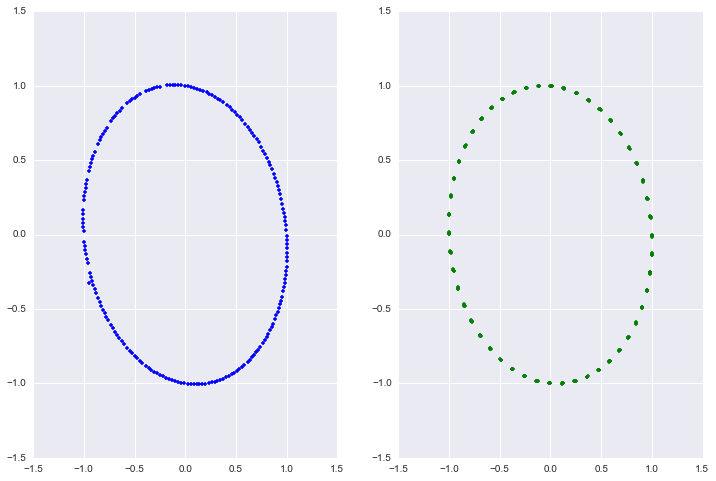

In [10]:
U = lambda q: q**2/2
K = lambda p:  (p**2)/2
dUdq= lambda q: q

def leapfrog(p0, q0, L, epsilon):
    
    ps = [p0]
    qs = [q0]
    
    p = p0
    q = q0
    
    # Make a half step for momentum at the beginning
    p = p - epsilon*dUdq(q)/2.0

    # alternate full steps for position and momentum
    for i in xrange(L):
        q = q + epsilon*p
        qs.append(q)
        if (i != L-1):
            p = p - epsilon*dUdq(q)
            ps.append(p)

    #make a half step at the end
    p = p - epsilon*dUdq(q)/2.
    ps.append(p)
    
    return (ps, qs)



l1ps,l1qs = leapfrog(1,0, 200, 0.21 )
l2ps,l2qs = leapfrog(1,0, 200, np.pi/25)

plt.figure(figsize=[12,8])
plt.subplot(1,2,1)
plt.plot(l1qs,l1ps, 'b.')
plt.subplot(1,2,2)
plt.plot(l2qs,l2ps, 'g.')


## Other considerations 

* Performance vs M-H
* Performance for correlated distributions
* Tuning L, $\epsilon $
* Autocorrelation, traceplots and other metrics of convergence.



